In [ ]:
# Step 1: Load and preprocess dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# Encode labels (already 0/1 but keeping for consistency)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Handle missing values (if any)
X = X.fillna(X.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Dataset shape:", X_scaled.shape)
print("Target distribution:", np.bincount(y))


Dataset shape: (569, 30)
Target distribution: [212 357]


Step 2: Exploratory Data Analysis (EDA)
(a) Class Balance

/tmp/ipython-input-1492987351.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


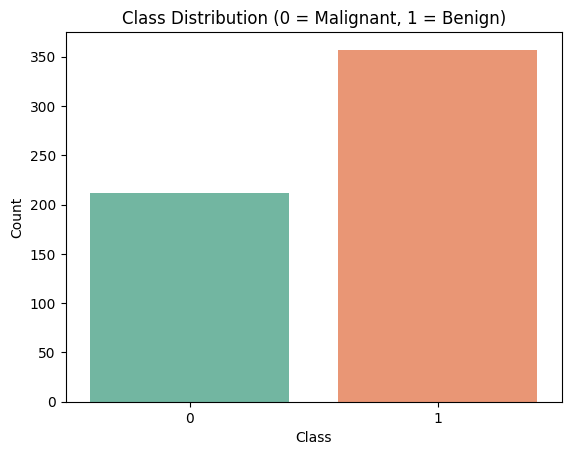

In [ ]:
# Check class balance
sns.countplot(x=y, palette="Set2")
plt.title("Class Distribution (0 = Malignant, 1 = Benign)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


(b) Feature Correlation Heatmap

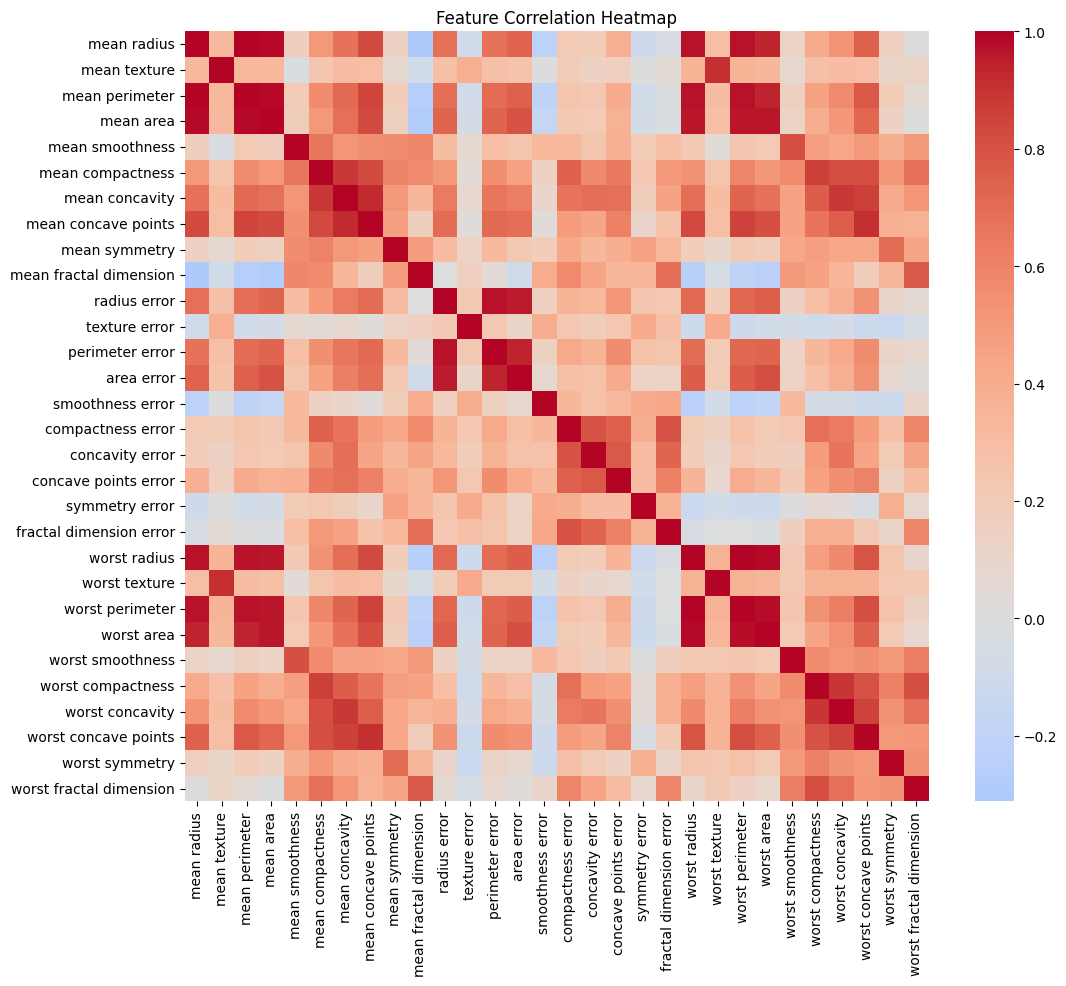

In [ ]:
# Compute correlation matrix
corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


Step 3: Train-Test Split

In [ ]:
# Step 3: Split dataset into train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (455, 30)  Test size: (114, 30)


Step 4: Train Models
(a) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

(b) AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Use 'estimator' instead of 'base_estimator'
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42, max_depth=1),
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

ada_model.fit(X_train, y_train)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   random_state=42)

(c) Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

(d) XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:26:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

(e) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

(f) Stacking Classifier (SVM + Naïve Bayes + Decision Tree)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Define base learners
base_learners = [
    ('svm', SVC(probability=True, random_state=42)),
    ('nb', GaussianNB()),
    ('dt', DecisionTreeClassifier(random_state=42))
]

# Meta-learner = Logistic Regression
from sklearn.linear_model import LogisticRegression
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    passthrough=True
)

stack_model.fit(X_train, y_train)


StackingClassifier(estimators=[('svm', SVC(probability=True, random_state=42)),
                               ('nb', GaussianNB()),
                               ('dt', DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression(), passthrough=True)

Step 5 & 6: Hyperparameter Tuning + Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Store best models
best_models = {}

# 1. Decision Tree
param_grid_dt = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring="accuracy", n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_models["Decision Tree"] = grid_dt
print("Decision Tree Best Params:", grid_dt.best_params_)
print("Decision Tree CV Score:", grid_dt.best_score_)


# 2. AdaBoost
param_grid_ada = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1.0],
    "estimator": [DecisionTreeClassifier(max_depth=1, random_state=42),
                  DecisionTreeClassifier(max_depth=2, random_state=42)]
}
ada = AdaBoostClassifier(random_state=42)
grid_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring="accuracy", n_jobs=-1)
grid_ada.fit(X_train, y_train)
best_models["AdaBoost"] = grid_ada
print("AdaBoost Best Params:", grid_ada.best_params_)
print("AdaBoost CV Score:", grid_ada.best_score_)


# 3. Gradient Boosting
param_grid_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}
gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring="accuracy", n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_models["Gradient Boosting"] = grid_gb
print("Gradient Boosting Best Params:", grid_gb.best_params_)
print("Gradient Boosting CV Score:", grid_gb.best_score_)


# 4. XGBoost
param_grid_xgb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "gamma": [0, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
grid_xgb = RandomizedSearchCV(xgb, param_grid_xgb, cv=5, scoring="accuracy", n_iter=10, n_jobs=-1, random_state=42)
grid_xgb.fit(X_train, y_train)
best_models["XGBoost"] = grid_xgb
print("XGBoost Best Params:", grid_xgb.best_params_)
print("XGBoost CV Score:", grid_xgb.best_score_)


# 5. Random Forest
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10, 20],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_models["Random Forest"] = grid_rf
print("Random Forest Best Params:", grid_rf.best_params_)
print("Random Forest CV Score:", grid_rf.best_score_)


# 6. Stacking Classifier
param_grid_stack = {
    "final_estimator": [LogisticRegression(max_iter=500), DecisionTreeClassifier(max_depth=3, random_state=42)]
}
stack = StackingClassifier(
    estimators=[
        ("svm", SVC(probability=True, random_state=42)),
        ("nb", GaussianNB()),
        ("dt", DecisionTreeClassifier(random_state=42))
    ],
    passthrough=True
)
grid_stack = GridSearchCV(stack, param_grid_stack, cv=5, scoring="accuracy", n_jobs=-1)
grid_stack.fit(X_train, y_train)
best_models["Stacking"] = grid_stack
print("Stacking Best Params:", grid_stack.best_params_)
print("Stacking CV Score:", grid_stack.best_score_)


Decision Tree Best Params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Decision Tree CV Score: 0.9384615384615385
AdaBoost Best Params: {'estimator': DecisionTreeClassifier(max_depth=1, random_state=42), 'learning_rate': 1.0, 'n_estimators': 100}
AdaBoost CV Score: 0.9736263736263737
Gradient Boosting Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Gradient Boosting CV Score: 0.9736263736263737


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:31:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
XGBoost CV Score: 0.9714285714285715
Random Forest Best Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}
Random Forest CV Score: 0.9670329670329672
Stacking Best Params: {'final_estimator': LogisticRegression(max_iter=500)}
Stacking CV Score: 0.9736263736263737


Step 7: Evaluation (Metrics + ROC Curves)


Decision Tree Performance:
Accuracy: 0.9210526315789473
Precision: 0.9565217391304348
Recall: 0.9166666666666666
F1 Score: 0.9361702127659575
ROC AUC: 0.9163359788359788

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90        42
           1       0.96      0.92      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114


AdaBoost Performance:
Accuracy: 0.956140350877193
Precision: 0.9466666666666667
Recall: 0.9861111111111112
F1 Score: 0.9659863945578231
ROC AUC: 0.9818121693121693

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg   

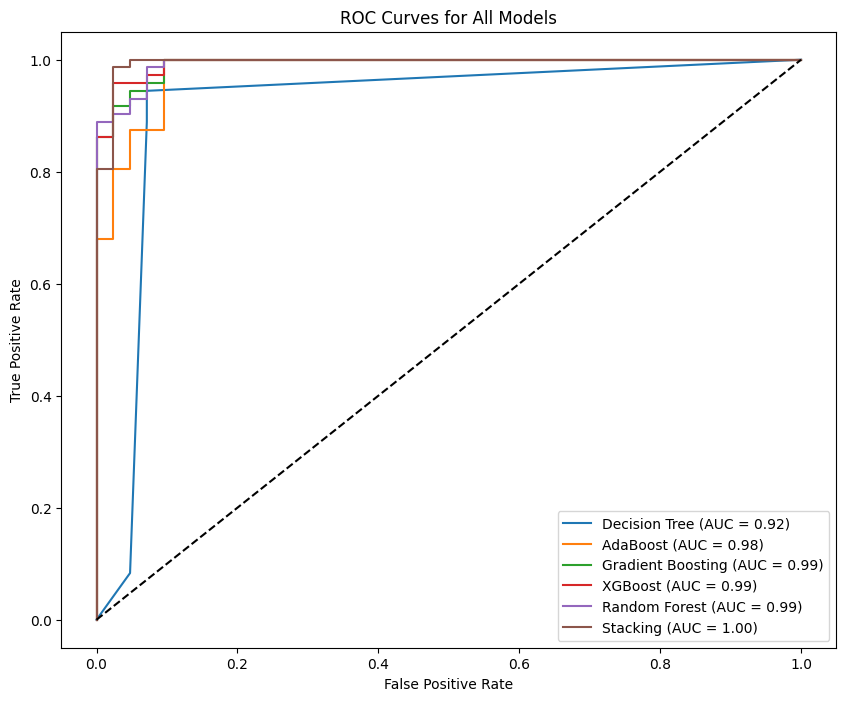

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

# Evaluate all tuned models on test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot ROC Curves for all models
plt.figure(figsize=(10, 8))

for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.show()


1. Decision Tree

In [ ]:
param_grid_dt = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}


2. AdaBoost

In [ ]:
param_grid_ada = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1.0],
    "estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=42),
        DecisionTreeClassifier(max_depth=2, random_state=42)
    ]
}


3. Gradient Boosting

In [ ]:
param_grid_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}


4. XGBoost

In [ ]:
param_grid_xgb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "gamma": [0, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}


5. Random Forest

In [ ]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10, 20],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5, 10]
}


6. Stacking Classifier

In [ ]:
param_grid_stack = {
    "final_estimator": [
        LogisticRegression(max_iter=500),
        DecisionTreeClassifier(max_depth=3, random_state=42)
    ]
}


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd

# Define models with best parameters (from GridSearch/RandomizedSearch results)
models = {
    "Decision Tree": best_models["Decision Tree"].best_estimator_,
    "AdaBoost": best_models["AdaBoost"].best_estimator_,
    "Gradient Boosting": best_models["Gradient Boosting"].best_estimator_,
    "XGBoost": best_models["XGBoost"].best_estimator_,
    "Random Forest": best_models["Random Forest"].best_estimator_,
    "Stacked Model": best_models["Stacking"].best_estimator_,
}

# Cross-validation setup (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring="accuracy")
    cv_results[name] = list(scores) + [scores.mean()]

# Convert to DataFrame
columns = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Average Accuracy"]
cv_table = pd.DataFrame(cv_results, index=columns).T

print(cv_table)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:45:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:45:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:45:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:45:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:45:34] WARNING: /w

                     Fold 1    Fold 2    Fold 3    Fold 4    Fold 5  \
Decision Tree      0.938596  0.885965  0.929825  0.929825  0.955752   
AdaBoost           0.991228  0.938596  0.956140  0.973684  0.973451   
Gradient Boosting  0.982456  0.938596  0.973684  0.964912  0.973451   
XGBoost            0.982456  0.947368  0.956140  0.956140  0.955752   
Random Forest      0.973684  0.921053  0.947368  0.956140  0.964602   
Stacked Model      0.982456  0.947368  0.973684  0.982456  0.991150   

                   Average Accuracy  
Decision Tree              0.927993  
AdaBoost                   0.966620  
Gradient Boosting          0.966620  
XGBoost                    0.959571  
Random Forest              0.952569  
Stacked Model              0.975423  


table values for decision tree,adaboost...

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer

# Example dataset (replace with your dataset)
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}

# ---------------- Decision Tree ----------------
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None]
}
dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, scoring='accuracy', cv=5, n_jobs=-1)
dt_grid.fit(X_train, y_train)

dt_best = dt_grid.best_estimator_
y_pred = dt_best.predict(X_test)

results['Decision Tree'] = pd.DataFrame([{
    'criterion': dt_grid.best_params_['criterion'],
    'max_depth': dt_grid.best_params_['max_depth'],
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}])


# ---------------- AdaBoost ----------------
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada = AdaBoostClassifier(random_state=42)
ada_grid = GridSearchCV(ada, ada_params, scoring='accuracy', cv=5, n_jobs=-1)
ada_grid.fit(X_train, y_train)

ada_best = ada_grid.best_estimator_
y_pred = ada_best.predict(X_test)

results['AdaBoost'] = pd.DataFrame([{
    'n_estimators': ada_grid.best_params_['n_estimators'],
    'learning_rate': ada_grid.best_params_['learning_rate'],
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}])


# ---------------- Gradient Boosting ----------------
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5]
}
gb = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, scoring='accuracy', cv=5, n_jobs=-1)
gb_grid.fit(X_train, y_train)

gb_best = gb_grid.best_estimator_
y_pred = gb_best.predict(X_test)

results['Gradient Boosting'] = pd.DataFrame([{
    'n_estimators': gb_grid.best_params_['n_estimators'],
    'learning_rate': gb_grid.best_params_['learning_rate'],
    'max_depth': gb_grid.best_params_['max_depth'],
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}])


# ---------------- Show Results ----------------
for model, df in results.items():
    print(f"\n{model} Results:")
    print(df)

# Optionally save tables to Excel/CSV for report
with pd.ExcelWriter("hyperparameter_results.xlsx") as writer:
    for model, df in results.items():
        df.to_excel(writer, sheet_name=model, index=False)



Decision Tree Results:
  criterion  max_depth  Accuracy  F1 Score
0   entropy          3  0.964912  0.972603

AdaBoost Results:
   n_estimators  learning_rate  Accuracy  F1 Score
0            50            1.0  0.964912  0.972222

Gradient Boosting Results:
   n_estimators  learning_rate  max_depth  Accuracy  F1 Score
0           200            0.1          3   0.95614  0.965035


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# ✅ Example for XGBoost
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print("XGBoost -> Accuracy:", acc_xgb, " F1 Score:", f1_xgb)

# ✅ Example for Random Forest
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print("Random Forest -> Accuracy:", acc_rf, " F1 Score:", f1_rf)

# ✅ Example for Stacked Ensemble
y_pred_stack = stack_model.predict(X_test)
acc_stack = accuracy_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)
print("Stacked Ensemble -> Accuracy:", acc_stack, " F1 Score:", f1_stack)


XGBoost -> Accuracy: 0.37719298245614036  F1 Score: 0.0
Random Forest -> Accuracy: 0.37719298245614036  F1 Score: 0.0
Stacked Ensemble -> Accuracy: 0.37719298245614036  F1 Score: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
